Investigate the sgl cover, slopes, elevation, etc... of a single glacier

In [1]:
import os
import rasterio as rio
import numpy as np
import shapely 
import pyproj
import geopandas as gpd
import matplotlib.pyplot as plt
import rioxarray as riox
import rasterio as rio
import xarray as xr
import netCDF4
from osgeo import gdal
import pandas as pd
from datetime import datetime
import dask.array
import matplotlib as mpl

In [2]:
# define folder and file paths
folder_HMA = os.path.join('C:',os.sep,'Users','lzell','OneDrive - Colostate','Desktop',"HMA2")
folder_glaciers = os.path.join(folder_HMA, 'Glacier Products')
folder_datasets = os.path.join(folder_HMA, 'Datasets')
fp_rgi = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_full_rgi.shp')
fp_dc = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'AOI_dc_rgi.shp')
fp_regions = os.path.join(folder_HMA, 'Datasets', 'AOI definition', 'Final AOI', "Final Products", 'subregion_boundaries.shp')

In [3]:
# open the rgi gdf, regions gdf
rgi_gdf = gpd.read_file(fp_rgi).to_crs("ESRI:102025")
dc_gdf = gpd.read_file(fp_dc).to_crs("ESRI:102025")
regions_gdf = gpd.read_file(fp_regions).to_crs("ESRI:102025")

# add the o3region as a column to each rgi
regions_gdf = regions_gdf.rename({"id":"o3region"}, axis=1)
rgi_gdf = rgi_gdf.sjoin(regions_gdf[["o3region","geometry"]])
dc_gdf = dc_gdf.sjoin(regions_gdf[["o3region","geometry"]])

In [4]:
# matplotlib stuff
mpl.rcParams['font.family'] = 'Arial'
mpl.rcParams['mathtext.fontset'] = 'custom'
mpl.rcParams['mathtext.rm'] = 'Arial'

In [7]:
# function to get all the data for a given glacier
def get_single_glacier_info(rgi_id, glacier_name):
    # plot annual timeseries of a single glacier ( provide either glacier name or rgi_id)
    rgi_id = rgi_id # choose which you want to provide
    glacier_name = glacier_name

    # get the rgi_id if glacier name was provided
    if glacier_name: rgi_id = rgi_gdf[rgi_gdf['glac_name'].str.contains(glacier_name)==True]['rgi_id'].values[0]

    # open the csvs hold water, elevation, slope, etc... by distance
    df_z = pd.read_csv(os.path.join(folder_glaciers, rgi_id, "Base Products", "glacier_slopes.csv"))
    df_dca = pd.read_csv(os.path.join(folder_glaciers, rgi_id, "Base Products", "glacier_dca_distances.csv"))
    df_v = pd.read_csv(os.path.join(folder_glaciers, rgi_id, "Base Products", "glacier_velocity_distances.csv"))
    df_dhdt = pd.read_csv(os.path.join(folder_glaciers, rgi_id, "Base Products", "glacier_dhdt_distances.csv"))
    df_dthick = pd.read_csv(os.path.join(folder_glaciers, rgi_id, "Base Products", "glacier_debristhickness_distances.csv"))
    df_sgls = pd.read_csv(os.path.join(folder_glaciers, rgi_id, "Water", "glacier_water_distances.csv"))
    
    return (df_z, df_dca, df_v, df_dhdt, df_dthick, df_sgls)

In [172]:
def plot_single_glacier(rgi_id, glacier_name):
    
    # get the dfs with glacier info
    df_z, df_dca, df_v, df_dhdt, df_dthick, df_sgls = get_single_glacier_info(rgi_id, glacier_name)
    
    # get the names of glacier segments
    branch_ns = [ i.split("_")[0] for i in df_v.columns[1:] ]

    
    ### initiate figure. one subplot for each
    fig,axs = plt.subplots(5,1, figsize=(8,10), sharex=True)
    
    # plot water frequency by distance, after smoothing a bit
    df_sgls_p = df_sgls.set_index('distance').rolling(21, min_periods=1, center=True).sum().reset_index()
    df_dca_p = df_dca.set_index('distance').rolling(21, min_periods=1, center=True).sum().reset_index()
    
    # aggregate sgls within timeframes
    times = [ [1988,1999], [2000,2004], [2005,2009], [2010,2014], [2015,2019], [2020,2023] ]
    colors_to_use = ['slateblue'] + list(plt.cm.Spectral_r(np.linspace(0.1,1, 4))) + ['0.1']
    
    df_sgl_bins = pd.DataFrame({"distance":df_sgls_p['distance']})
    for i,n in enumerate(branch_ns):
        for ts in times:
            subset = [ f"{n}_{y}" for y in range(ts[0],ts[1]+1) ]
            subset = df_sgls_p[ [ i for i in subset if i in list(df_sgls_p.columns) ] ]
            subset = subset.mean(axis=1)/df_dca_p[f'{n}_dca']*100
            df_sgl_bins[f'{n}_{ts[0]}_{ts[1]}'] = subset

    # plot sgl frequency
    for i,n in enumerate(branch_ns):
        for t_i in range(len(times)):
            axs[0].plot( df_sgl_bins['distance'], df_sgl_bins[f'{n}_{times[t_i][0]}_{times[t_i][1]}'],
                        zorder=2, c=colors_to_use[t_i], linestyle='solid', linewidth=3,
                        label=f'{times[t_i][0]}_{times[t_i][1]}')
    axs[0].set_ylabel("SGL Area (%)")
    axs[0].legend(loc='upper right')
    
    
    # plot dhdt
    times = [ "2000-01-01_2020-01-01", "2000-01-01_2005-01-01", "2005-01-01_2010-01-01", "2010-01-01_2015-01-01", "2015-01-01_2020-01-01", ]
    colors_to_use = ['black'] + list(plt.cm.Spectral_r(np.linspace(0.1,1, len(times)-1)))
    
    for i,n in enumerate(branch_ns):
        for t_i in range(len(times)):
            axs[1].plot( df_dhdt['distance'], df_dhdt[f'{n}_{times[t_i]}'], zorder=2,
                         c=colors_to_use[t_i], linestyle='solid', linewidth=3,
                         label= f"{times[t_i].split('_')[0][:4]}-{times[t_i].split('_')[1][:4]}" )
    axs[1].set_ylabel("dhdt (m/yr)")
    axs[1].legend(loc='upper right')
        

    # plot slope
    for i,n in enumerate(branch_ns):
        p = axs[2].plot( df_z['distance'], df_z[f'{n}_slope'], zorder=2)
    axs[2].set_ylabel("Slope (degrees)")
    
    
    
    # plot velocity
    for i,n in enumerate(branch_ns):
        p = axs[3].plot( df_v['distance'], df_v[f'{n}_velocity'], zorder=2, c='black')
    axs[3].set_ylabel("Velocity (m/yr)")
    
    
    # plot debris thickness
    for i,n in enumerate(branch_ns):
        p = axs[4].plot( df_dthick['distance'], df_dthick[f'{n}_debristhickness'], zorder=2, c='black')
    axs[4].set_ylabel("Debris Thickness (m)")
    
    
             
    
    axs[-1].set_xlabel("Distance from terminus (m)")
    for ax in axs:
        ax.grid(zorder=1, linestyle='dashed', linewidth=1)
        
    plt.tight_layout()

C:\Users\lzell\AppData\Local\Temp\ipykernel_15284\630803332.py:78: UserWarning: Tight layout not applied. tight_layout cannot make axes height small enough to accommodate all axes decorations.
  plt.tight_layout()


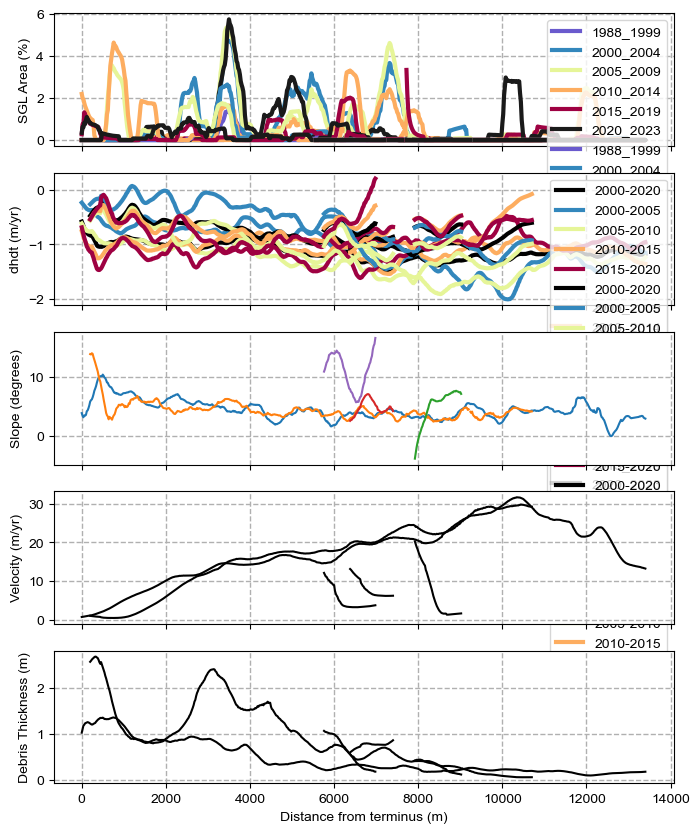

In [189]:
rgi_id = 'RGI2000-v7.0-G-15-00882' # choose which you want to provide
glacier_name = ''
df_z, df_dca, df_v, df_dhdt, df_dthick, df_sgls = get_single_glacier_info(rgi_id, glacier_name)
plot_single_glacier(rgi_id, glacier_name)